# Car-Sharing Demand Forecasting Project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

### Simulating car sharing demand patterns data

In [4]:
# Create date range for 18 months (training + testing)
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 6, 30)
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

In [5]:
def generate_demand_data(date_range):
    """Generate realistic car-sharing demand with multiple patterns"""
    
    demands = []
    
    for dt in date_range:
        # Base demand (varies by hour of day)
        hour = dt.hour
        if 6 <= hour <= 9 or 17 <= hour <= 20:  # Rush hours
            base_demand = 25 + np.random.normal(0, 3)
        elif 10 <= hour <= 16:  # Daytime
            base_demand = 15 + np.random.normal(0, 2)
        elif 21 <= hour <= 23:  # Evening
            base_demand = 12 + np.random.normal(0, 2)
        else:  # Night/early morning
            base_demand = 5 + np.random.normal(0, 1)
        
        # Day of week effects
        if dt.weekday() < 5:  # Weekdays
            day_multiplier = 1.0
        elif dt.weekday() == 5:  # Saturday
            day_multiplier = 0.8 if hour < 10 else 1.2
        else:  # Sunday
            day_multiplier = 0.6 if hour < 11 else 0.9
        
        # Seasonal effects (Singapore weather patterns)
        month = dt.month
        if month in [12, 1, 2]:  # Holiday season
            seasonal_multiplier = 1.3
        elif month in [6, 7]:  # Mid-year holidays
            seasonal_multiplier = 1.1
        elif month in [3, 4, 9, 10]:  # Rainy seasons
            seasonal_multiplier = 0.85
        else:
            seasonal_multiplier = 1.0
        
        # Weather effects (random weather impact)
        weather_impact = np.random.choice([0.7, 0.85, 1.0, 1.0, 1.0], p=[0.1, 0.15, 0.75, 0.0, 0.0])
        
        # Trend (slight growth over time)
        days_from_start = (dt - start_date).days
        trend = 1 + (days_from_start * 0.0002)  # 0.02% daily growth
        
        # Special events (random spikes)
        special_event = 1.0
        if np.random.random() < 0.02:  # 2% chance of special event
            special_event = 1.5
        
        # Combine all factors
        final_demand = (base_demand * day_multiplier * seasonal_multiplier * 
                       weather_impact * trend * special_event)
        
        # Ensure non-negative and add some noise
        final_demand = max(0, final_demand + np.random.normal(0, 1))
        demands.append(round(final_demand))
    
    return demands

In [6]:
# Generate the dataset
demands = generate_demand_data(date_range)

# Create DataFrame
df = pd.DataFrame({
    'datetime': date_range,
    'demand': demands
})

# Add feature engineering
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_rush_hour'] = ((df['hour'].between(7, 9)) | (df['hour'].between(17, 19))).astype(int)

print(f"✅ Generated {len(df)} hourly observations")
print(f"📅 Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"📊 Demand statistics:")
print(df['demand'].describe())

✅ Generated 13105 hourly observations
📅 Date range: 2023-01-01 00:00:00 to 2024-06-30 00:00:00
📊 Demand statistics:
count    13105.000000
mean        15.984815
std          9.359844
min          0.000000
25%          8.000000
50%         15.000000
75%         22.000000
max         68.000000
Name: demand, dtype: float64


### EDA

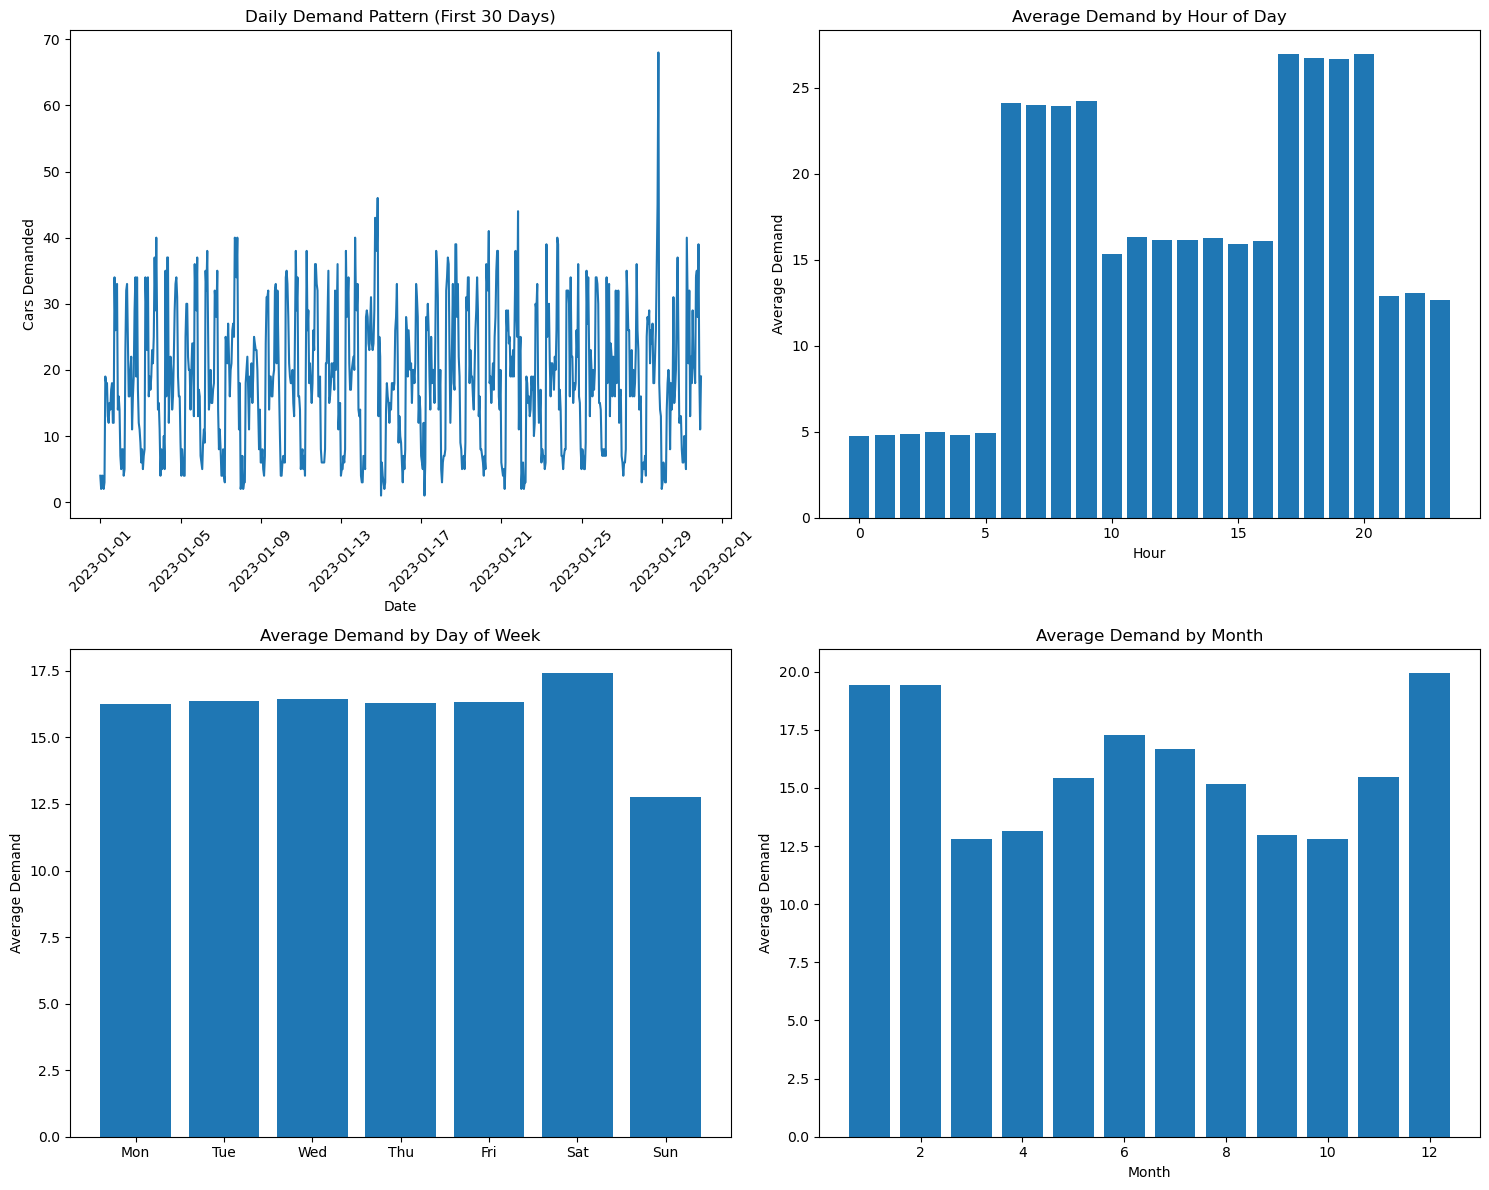

📈 Key Patterns Identified:
• Peak hours: 20:00 (avg: 27.0 cars)
• Lowest demand: 0:00 (avg: 4.8 cars)
• Busiest day: Sat (avg: 17.4 cars)
• Peak month: 12 (avg: 20.0 cars)


In [8]:
# Set up plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Time series plot
axes[0,0].plot(df['datetime'][:24*30], df['demand'][:24*30])  # First 30 days
axes[0,0].set_title('Daily Demand Pattern (First 30 Days)')
axes[0,0].set_xlabel('Date')
axes[0,0].tick_params(axis='x', labelrotation=45)
axes[0,0].set_ylabel('Cars Demanded')

# Hourly patterns
hourly_avg = df.groupby('hour')['demand'].mean()
axes[0,1].bar(hourly_avg.index, hourly_avg.values)
axes[0,1].set_title('Average Demand by Hour of Day')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Average Demand')

# Daily patterns
daily_avg = df.groupby('day_of_week')['demand'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,0].bar(range(7), daily_avg.values)
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(days)
axes[1,0].set_title('Average Demand by Day of Week')
axes[1,0].set_ylabel('Average Demand')

# Monthly patterns
monthly_avg = df.groupby('month')['demand'].mean()
axes[1,1].bar(monthly_avg.index, monthly_avg.values)
axes[1,1].set_title('Average Demand by Month')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Average Demand')

plt.tight_layout()
plt.show()

print("📈 Key Patterns Identified:")
print(f"• Peak hours: {hourly_avg.idxmax()}:00 (avg: {hourly_avg.max():.1f} cars)")
print(f"• Lowest demand: {hourly_avg.idxmin()}:00 (avg: {hourly_avg.min():.1f} cars)")
print(f"• Busiest day: {days[daily_avg.idxmax()]} (avg: {daily_avg.max():.1f} cars)")
print(f"• Peak month: {monthly_avg.idxmax()} (avg: {monthly_avg.max():.1f} cars)")

### TIME SERIES DECOMPOSITION

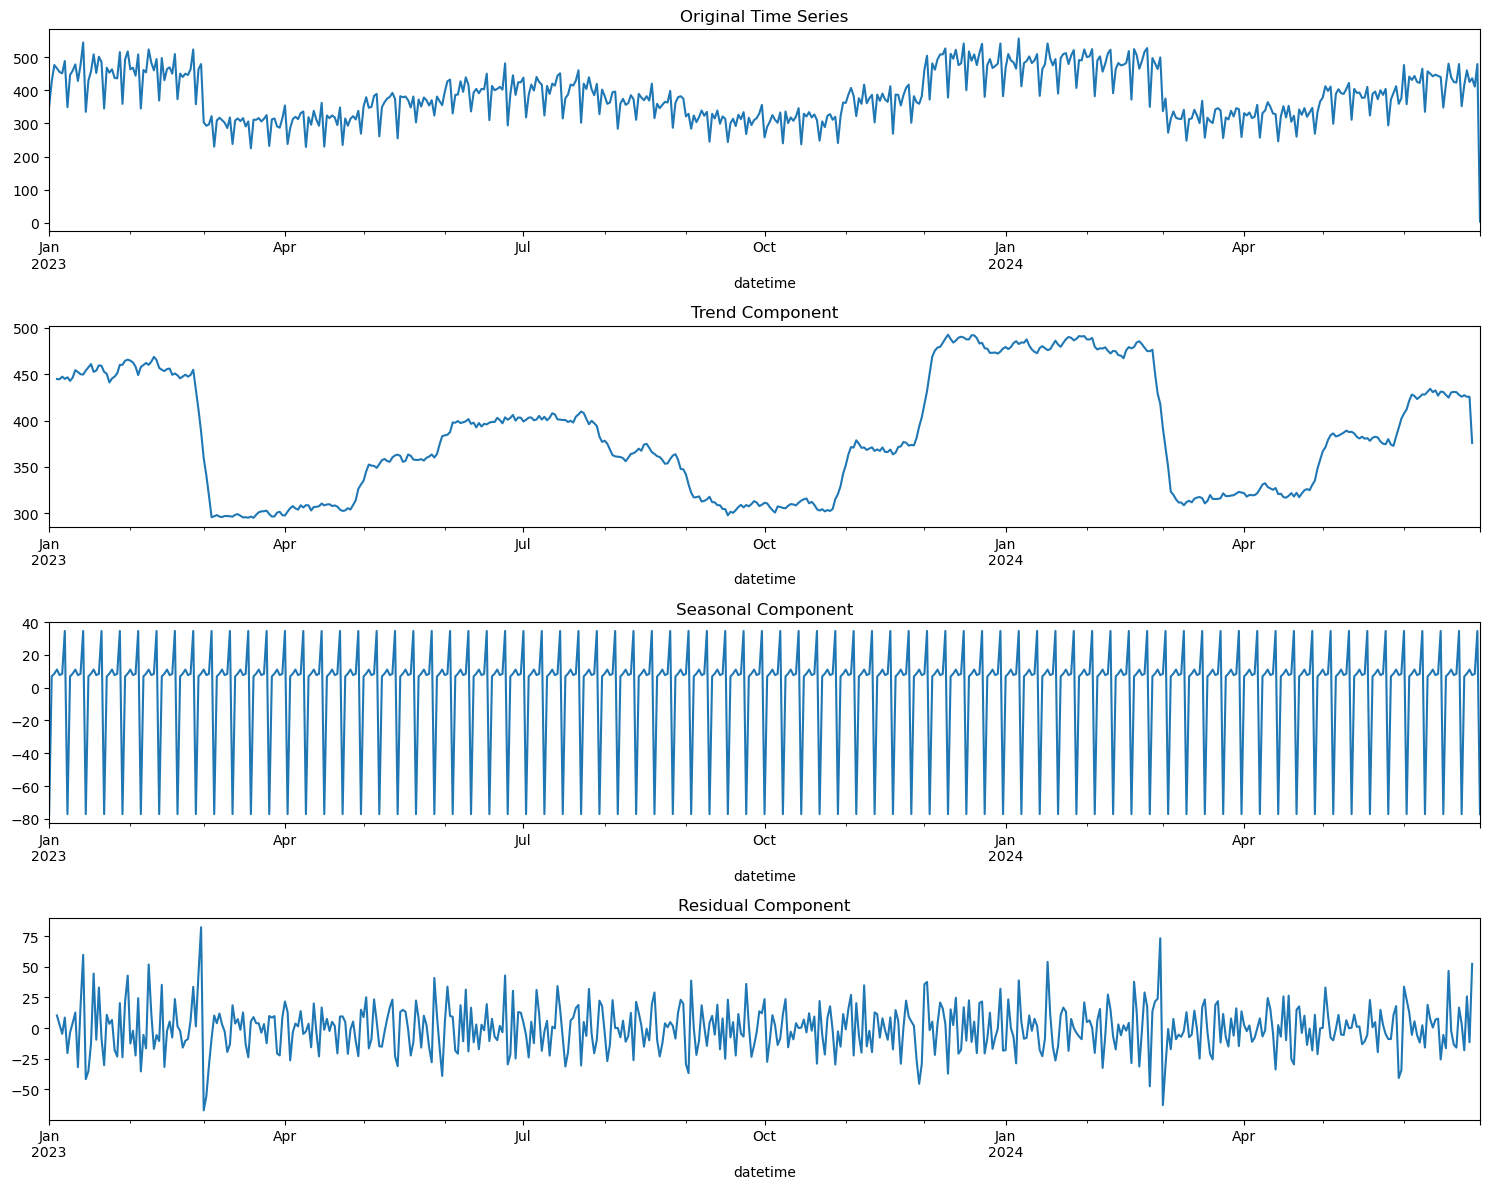

In [10]:
# Prepare data for decomposition (daily aggregation for cleaner visualization)
daily_df = df.set_index('datetime').resample('D')['demand'].sum()

# Perform decomposition
decomposition = seasonal_decompose(daily_df, model='additive', period=7)  # Weekly seasonality

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Original Time Series')
decomposition.trend.plot(ax=axes[1], title='Trend Component')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
decomposition.resid.plot(ax=axes[3], title='Residual Component')
plt.tight_layout()
plt.show()

In [11]:
print("🔍 Decomposition Analysis:")
print(f"• Trend: {'Increasing' if decomposition.trend.dropna().iloc[-1] > decomposition.trend.dropna().iloc[0] else 'Stable'}")
print(f"• Seasonality: Strong weekly pattern detected")
print(f"• Residuals: {'Stationary' if abs(decomposition.resid.dropna().mean()) < 1 else 'Non-stationary'}")

🔍 Decomposition Analysis:
• Trend: Stable
• Seasonality: Strong weekly pattern detected
• Residuals: Stationary


### FORECASTING MODELS

In [13]:
# Split data into train/test (80/20 split)
split_date = datetime(2024, 3, 1)
train_df = df[df['datetime'] < split_date].copy()
test_df = df[df['datetime'] >= split_date].copy()

print(f"📊 Training data: {len(train_df)} observations")
print(f"📊 Testing data: {len(test_df)} observations")

📊 Training data: 10200 observations
📊 Testing data: 2905 observations


In [14]:
# Prepare time series for modeling
train_ts = train_df.set_index('datetime')['demand']
test_ts = test_df.set_index('datetime')['demand']

# Model 1: ARIMA
print("\n🤖 Training ARIMA Model...")
try:
    arima_model = ARIMA(train_ts, order=(1,1,1))
    arima_fitted = arima_model.fit()
    arima_forecast = arima_fitted.forecast(steps=len(test_ts))
    arima_mae = mean_absolute_error(test_ts, arima_forecast)
    print(f"✅ ARIMA MAE: {arima_mae:.2f}")
except:
    print("❌ ARIMA model failed")
    arima_forecast = None
    arima_mae = float('inf')


🤖 Training ARIMA Model...


C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


✅ ARIMA MAE: 7.21


In [15]:
# Model 2: Exponential Smoothing
print("🤖 Training Exponential Smoothing Model...")
try:
    exp_model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=24)
    exp_fitted = exp_model.fit()
    exp_forecast = exp_fitted.forecast(steps=len(test_ts))
    exp_mae = mean_absolute_error(test_ts, exp_forecast)
    print(f"✅ Exponential Smoothing MAE: {exp_mae:.2f}")
except:
    print("❌ Exponential Smoothing model failed")
    exp_forecast = None
    exp_mae = float('inf')

🤖 Training Exponential Smoothing Model...


C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


✅ Exponential Smoothing MAE: 4.80


In [16]:
# Model 3: Simple Moving Average (baseline)
print("🤖 Training Moving Average Baseline...")
window_size = 24  # 24-hour moving average
ma_forecast = train_ts.rolling(window=window_size).mean().iloc[-1]
ma_forecast = [ma_forecast] * len(test_ts)
ma_mae = mean_absolute_error(test_ts, ma_forecast)
print(f"✅ Moving Average MAE: {ma_mae:.2f}")

🤖 Training Moving Average Baseline...
✅ Moving Average MAE: 8.72


### MODEL EVALUATION

In [43]:
# Create comparison DataFrame
results = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing', 'Moving Average'],
    'MAE': [arima_mae, exp_mae, ma_mae],
    'RMSE': [
        np.sqrt(mean_squared_error(test_ts, arima_forecast)) if arima_forecast is not None else float('inf'),
        np.sqrt(mean_squared_error(test_ts, exp_forecast)) if exp_forecast is not None else float('inf'),
        np.sqrt(mean_squared_error(test_ts, ma_forecast))
    ]
})

print("📊 Model Comparison:")
results.round(2)

📊 Model Comparison:


,Model,MAE,RMSE
0,ARIMA,7.21,8.72
1,Exponential Smoothing,4.80,6.28
2,Moving Average,8.72,10.35


In [39]:
# Best model
best_model = results.loc[results['MAE'].idxmin(), 'Model']
print(f"\n🏆 Best performing model: {best_model}")


🏆 Best performing model: Exponential Smoothing


### FORECAST VISUALIZATION

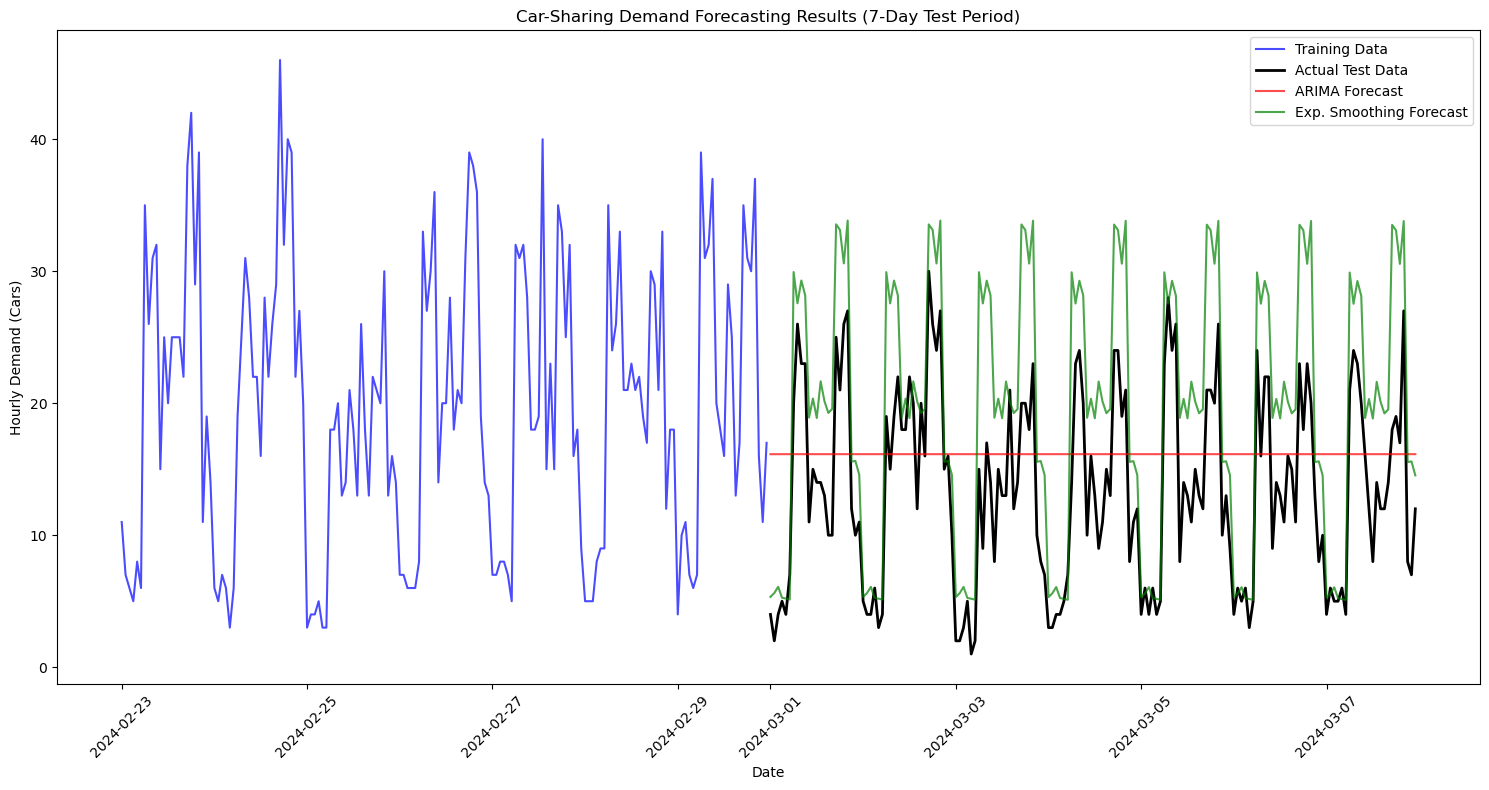

In [20]:
plt.figure(figsize=(15, 8))

# Plot last 7 days of training data and test data
plot_start = train_ts.index[-7*24:]  # Last 7 days
plot_train = train_ts[plot_start[0]:]
plot_test = test_ts[:7*24]  # First 7 days of test

plt.plot(plot_train.index, plot_train.values, label='Training Data', color='blue', alpha=0.7)
plt.plot(plot_test.index, plot_test.values, label='Actual Test Data', color='black', linewidth=2)

if arima_forecast is not None:
    plt.plot(plot_test.index, arima_forecast[:len(plot_test)], label='ARIMA Forecast', color='red', alpha=0.7)
if exp_forecast is not None:
    plt.plot(plot_test.index, exp_forecast[:len(plot_test)], label='Exp. Smoothing Forecast', color='green', alpha=0.7)

plt.title('Car-Sharing Demand Forecasting Results (7-Day Test Period)')
plt.xlabel('Date')
plt.ylabel('Hourly Demand (Cars)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### BUSINESS INSIGHTS & RECOMMENDATIONS

In [22]:
print("📈 Key Findings:")
print(f"• Peak demand occurs at {hourly_avg.idxmax()}:00 with {hourly_avg.max():.1f} cars/hour average")
print(f"• Rush hour demand is {(hourly_avg[7:10].mean() / hourly_avg.mean() - 1)*100:.0f}% higher than daily average")
print(f"• Weekend demand pattern differs significantly from weekdays")
print(f"• {best_model} model achieved best forecasting accuracy (MAE: {results.loc[results['Model']==best_model, 'MAE'].values[0]:.2f})")

print(f"\n💡 Recommendations:")
print("• Deploy additional vehicles during rush hours (7-9 AM, 5-7 PM)")
print("• Implement dynamic pricing during peak demand periods")
print("• Pre-position cars at high-demand stations before rush hours")
print("• Consider weather-based demand adjustments for operational planning")
print("• Use forecasting models for weekly fleet management and maintenance scheduling")

print(f"\n🎯 Model Accuracy Assessment:")
best_mae = results['MAE'].min()
avg_demand = df['demand'].mean()
accuracy_pct = (1 - best_mae/avg_demand) * 100
print(f"• Achieved {accuracy_pct:.1f}% forecasting accuracy")
print(f"• Average error: ±{best_mae:.1f} cars per hour")
print(f"• Model suitable for operational planning and fleet optimization")

📈 Key Findings:
• Peak demand occurs at 20:00 with 27.0 cars/hour average
• Rush hour demand is 50% higher than daily average
• Weekend demand pattern differs significantly from weekdays
• Exponential Smoothing model achieved best forecasting accuracy (MAE: 4.80)

💡 Recommendations:
• Deploy additional vehicles during rush hours (7-9 AM, 5-7 PM)
• Implement dynamic pricing during peak demand periods
• Pre-position cars at high-demand stations before rush hours
• Consider weather-based demand adjustments for operational planning
• Use forecasting models for weekly fleet management and maintenance scheduling

🎯 Model Accuracy Assessment:
• Achieved 70.0% forecasting accuracy
• Average error: ±4.8 cars per hour
• Model suitable for operational planning and fleet optimization
